# DLAV Project - Phase 3

In this notebook we will train a very simple planner and test its real-world performance.


The first step is to prepare the data. The code below will download the data from google drive and extract it here for your code to use. Whenever your session gets restarted, remember to re-run this cell to re-download the data.

In [ ]:
# Install gdown to handle Google Drive file download
!pip install -q gdown

import gdown
import zipfile

download_url = f"https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr"
output_zip = "dlav_train.zip"
gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=17DREGym_-v23f_qbkMHr7vJstbuTt0if"
output_zip = "dlav_val_real.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1_l6cui0pCJ_caixN0uTkkUOfu6ICO8u5"
output_zip = "test_public_real.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

Downloading...
From (original): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr
From (redirected): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr&confirm=t&uuid=042432ba-0022-40c7-b469-916c5fa9588b
To: /content/dlav_train.zip
100%|██████████| 439M/439M [00:07<00:00, 55.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=17DREGym_-v23f_qbkMHr7vJstbuTt0if
From (redirected): https://drive.google.com/uc?id=17DREGym_-v23f_qbkMHr7vJstbuTt0if&confirm=t&uuid=652aa425-89e7-47ef-bb1f-974cda8f0620
To: /content/dlav_val_real.zip
100%|██████████| 129M/129M [00:00<00:00, 132MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1_l6cui0pCJ_caixN0uTkkUOfu6ICO8u5
From (redirected): https://drive.google.com/uc?id=1_l6cui0pCJ_caixN0uTkkUOfu6ICO8u5&confirm=t&uuid=0930ea0f-a04b-4681-9ab1-2ca80d668259
To: /content/test_public_real.zip
100%|██████████| 110M/110M [00:00<00:00, 125MB/s]


Now lets load the data and visualize how the real data looks like!

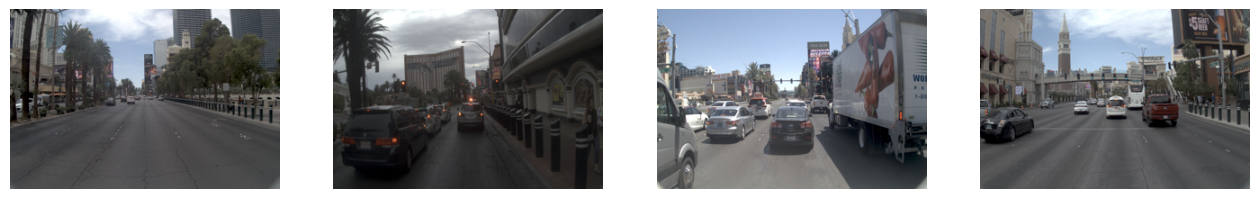

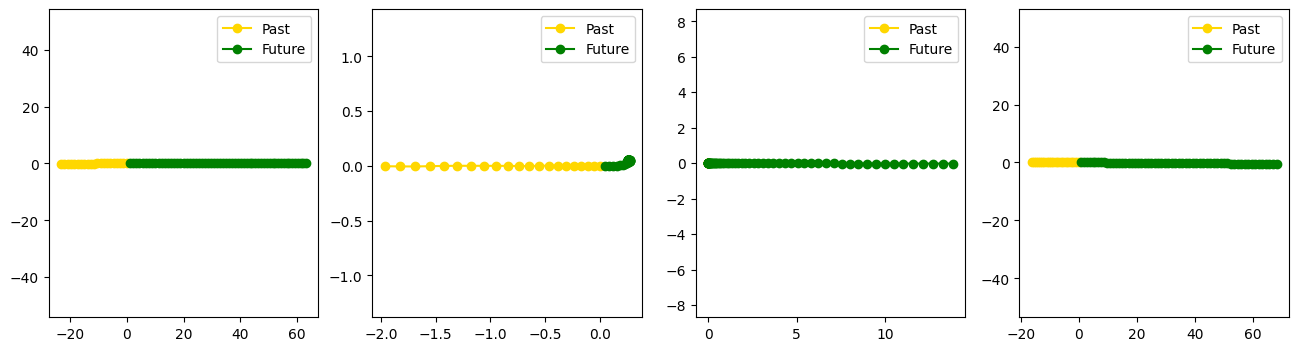

In [ ]:

import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import os
k = 4
# load the data
data = []
test_files = os.listdir("val_real")

for i in range(k):
    with open(f"val_real/{test_files[i]}", "rb") as f:
        data.append(pickle.load(f))

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["camera"])
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].plot(data[i]["sdc_history_feature"][:, 0], data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(data[i]["sdc_future_feature"][:, 0], data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

In [ ]:
import torch
import pickle
import os
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

from google.colab import drive
from torchvision import transforms
from torchvision import models
from torchvision.models import ResNet18_Weights
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

Now let's train the model with synthetic data and test it with the real-world data.

In [ ]:
import torch
from torch.utils.data import Dataset
import pickle

class DrivingDataset(Dataset):
    def __init__(self, file_list, test=False, val=False, augment=False):
        self.samples = file_list
        self.test = test
        self.val = val
        self.augment=augment

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to 224x224
       ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Load pickle file
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        # Convert numpy arrays to tensors
        camera = torch.FloatTensor(data['camera']).permute(2, 0, 1)
        camera = self.transform(camera)
        history = torch.FloatTensor(data['sdc_history_feature'])

        #command = data['driving_command']
        #command_map = {'left':0,'right':1,'forward': 2}
        #command = torch.tensor(command_map[command])

        if not self.test:
          future = torch.FloatTensor(data['sdc_future_feature'])


          return {
            'camera': camera,
            'history': history,
            'future': future,
            #'command': command
          }
        else:
          return {
            'camera': camera,
            'history': history
          }



In [ ]:
from torchvision import transforms
import random
import numpy as np
import torch # Import torch as it's used in __getitem__
import pickle # Import pickle as it's used in __getitem__


class DrivingDatasetPLUS(Dataset):
    def __init__(self, file_list, test=False, val=False, augment=False):
        self.samples = file_list
        self.test = test
        self.val = val
        self.augment = augment

        # Base transform (resize + normalize)
        self.base_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        # Strong augmentations (only applied if augment=True)
        self.augmentation_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)), # Small rotations/translations
            transforms.GaussianBlur(kernel_size=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.samples)

    def __getitem__(self, idx):
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        # --- Camera Augmentation ---
        camera = data['camera']
        if self.augment and not (self.test or self.val):
            camera = self.augmentation_transform(camera)
        else:
            camera = self.base_transform(camera)

        # --- History Augmentation ---
        history = data['sdc_history_feature'].copy()  # [21, 3]

        if self.augment and not (self.test or self.val):
            # Add Gaussian noise to trajectory
            noise = np.random.normal(0, 0.1, history.shape).astype(np.float32)
            history += noise

            # Randomly drop some history points (simulate occlusions)
            if random.random() < 0.3:
                drop_mask = np.random.rand(history.shape[0]) < 0.2  # Drop 20% of points
                history[drop_mask] = 0.0  # Zero-out dropped points

        history = torch.FloatTensor(history)

        if not self.test:
            future = torch.FloatTensor(data['sdc_future_feature'])
            return {'camera': camera, 'history': history, 'future': future}
        else:
            return {'camera': camera, 'history': history}

In [ ]:
class Logger:
    def __init__(self):
        # Placeholder for potential future configs (e.g., log_dir, wandb_enabled, etc.)
        pass

    def log(self, step=None, **metrics):
        """
        Logs the given metrics.

        Args:
            step (int, optional): The current step or epoch. Useful for tracking.
            **metrics: Arbitrary keyword arguments representing metric names and values.
        """
        prefix = f"[Step {step}] " if step is not None else ""
        metric_str = " | ".join(f"{k}: {v}" for k, v in metrics.items())
        # print(prefix + metric_str)

In [ ]:
class DrivingDatasetPLUS2(Dataset):
    def __init__(self, file_list, test=False, val=False, augment=False):
        self.samples = file_list
        self.test = test
        self.val = val
        self.augment = augment

        # Image transforms
        self.base_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.augmentation_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
            transforms.GaussianBlur(kernel_size=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        """Returns the number of samples in the dataset"""
        return len(self.samples)

    def _calculate_velocity(self, positions, dt=0.1):
        """Calculate smoothed velocity features"""
        velocities = np.zeros_like(positions)
        if len(positions) > 1:
            velocities[1:] = (positions[1:] - positions[:-1]) / dt

            # Smooth with moving average
            window_size = min(3, len(velocities))
            if window_size > 1:
                kernel = np.ones(window_size)/window_size
                velocities[:, 0] = np.convolve(velocities[:, 0], kernel, mode='same')
                velocities[:, 1] = np.convolve(velocities[:, 1], kernel, mode='same')

        return np.linalg.norm(velocities, axis=1, keepdims=True)  # Return magnitude

    def __getitem__(self, idx):
        # Load data
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        # Process camera
        camera = data['camera']
        if self.augment and not (self.test or self.val):
            camera = self.augmentation_transform(camera)
        else:
            camera = self.base_transform(camera)

        # Process history - maintain 3 features
        positions = data['sdc_history_feature'][:, :2].astype(np.float32)  # [21, 2]
        velocity_mag = self._calculate_velocity(positions)  # [21, 1]

        # Combine into [x, y, velocity_magnitude]
        history = np.concatenate([positions, velocity_mag], axis=1)  # [21, 3]

        # Augmentations
        if self.augment and not (self.test or self.val):
            # Add noise to positions
            history[:, :2] += np.random.normal(0, 0.05, history[:, :2].shape).astype(np.float32)

            # Add smaller noise to velocity
            history[:, 2:] += np.random.normal(0, 0.01, history[:, 2:].shape).astype(np.float32)

            # Random occlusions
            if random.random() < 0.3:
                occl_start = random.randint(0, len(history)-4)
                history[occl_start:occl_start+3] = 0

        # Convert to tensor
        history = torch.FloatTensor(history)

        if not self.test:
            future = torch.FloatTensor(data['sdc_future_feature'])
            return {'camera': camera, 'history': history, 'future': future}
        else:
            return {'camera': camera, 'history': history}

Note: Replace with your own planner below

In [ ]:
class CommandEncoder(nn.Module):
    """
    Pipeline for the driving_command input.
    Simple learnable embedding layer.
    Per batch;  string input
                [1xembed_dim] tensor output
    """
    def __init__(self,embed_dim=32):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=3, embedding_dim=embed_dim)

    def forward(self, command):
        return self.embedding(command)

In [ ]:
class CameraEncoder(nn.Module):
    """
    Pipeline for the camera input.
    Use ResNet18 architecture, 18-layer deep CNN. First weights are freezed.
    Per batch;  [224x224x3] tensor RGB camera input
                [1xoutput_dim] tensor output
    """
    def __init__(self,output_dim=256):
        super().__init__()

        # Load pretrained ResNet18, freeze first layer and modify last to match dimensions
        resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        for name, param in resnet.named_parameters():
            if name.startswith("conv1") or name.startswith("bn1") or name.startswith("layer1"):
                param.requires_grad = False

        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(512,output_dim)

    def forward(self, x):
        features = self.backbone(x)
        features = features.view(x.size(0), -1)  # [B,512]
        out = self.fc(features)               # [B,output_dim]
        return out

In [ ]:
class HistoryEncoder(nn.Module):
    """
    Pipeline for the sdc_history_feature input.
    Use Transformer blocks, output the last timestep.
    Per batch;  [21x3] tensor position history input
                [1xd_model] tensor output
    """
    def __init__(self,d_model=128,nhead=4,num_layers=2,dropout=0.1,seq_len=21):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_len, d_model))  # Learned positional embedding
        self.input_proj = nn.Linear(3, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model,
                                                   nhead,
                                                   dim_feedforward=4*d_model,
                                                   dropout=dropout,
                                                   batch_first=True) # Add batch_first=True
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

    def forward(self, history):
        x = self.input_proj(history)  # [B,21,d_model]
        x = x + self.pos_embedding
        #x = x.permute(1, 0, 2)
        out = self.transformer(x)
        return out[:, -1]  # last timestep; [B,d_model]

In [ ]:
class AttentionDecoder(nn.Module):
    """
    Decode the 3 input pipeline results.
    Use cross-attention blocks.
    Per batch;  processed camera, history and command input (respectively [1,camera_dim], [1,history_dim], [1,command_dim])
                [60,3] future position predictions
    """
    def __init__(self, output_dim=3, sequence_length=60,d_latent=128):
        super().__init__()
        self.d_latent=d_latent

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_latent, nhead=4, batch_first=True)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        self.fc = nn.Linear(d_latent, output_dim*sequence_length)

        self.proj_cam = nn.Linear(256, self.d_latent)
        self.proj_hist = nn.Linear(128,self.d_latent)
        #self.proj_com = nn.Linear(32,self.d_latent)

    def forward(self, camera_feat, history_feat): #, command_feat

        camera_feat=self.proj_cam(camera_feat)
        history_feat=self.proj_hist(history_feat)
        #command_feat=self.proj_com(command_feat)

        x = torch.stack([camera_feat, history_feat], dim=1) #, command_feat
        attn_out = self.encoder(x)  # [B,3,d_model]
        fused_feat = attn_out.mean(dim=1)  # [B,d_model]
        predictions = self.fc(fused_feat)
        future_pos = predictions.view(-1, 60, 3)


        return future_pos  # [B, 60, 3]

In [ ]:
class PerceiverDecoder(nn.Module): #worst performance thant AttentionDecoder
    def __init__(self, output_dim=3, sequence_length=60, d_latent=256):
        super().__init__()
        self.d_latent = d_latent

        # Perceiver IO components
        self.latent_array = nn.Parameter(torch.randn(32, d_latent))  # Learnable latent tokens

        # Add projection layers to match input feature dimensions to d_latent
        self.proj_cam = nn.Linear(256, self.d_latent) # Assuming camera_dim is 256
        self.proj_hist = nn.Linear(128, self.d_latent) # Assuming history_dim is 128

        self.cross_attn = nn.MultiheadAttention(d_latent, num_heads=4,  batch_first=True) # Add batch_first=True)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_latent, nhead=4, dim_feedforward=4*d_latent, batch_first=True), # Add batch_first=True
            num_layers=4
        )

        self.output_proj = nn.Linear(self.latent_array.shape[0] * d_latent, output_dim * sequence_length) # Adjust output projection size

    def forward(self, camera_feat, history_feat):
        # Project inputs to same dimension
        camera_feat_proj = self.proj_cam(camera_feat).unsqueeze(1)  # [B, 1, d_latent]
        history_feat_proj = self.proj_hist(history_feat).unsqueeze(1)  # [B, 1, d_latent]

        input_seq = torch.cat([camera_feat_proj, history_feat_proj], dim=1)  # [B, 2, d_latent]

        batch_size = input_seq.size(0)
        # Correct latent array expansion
        latent = self.latent_array.unsqueeze(0).expand(batch_size, -1, -1)  # [B, 32, d_latent]

        # Cross-attention between latent array and inputs
        # Note: query=latent, key=input_seq, value=input_seq
        x, _ = self.cross_attn(latent, input_seq, input_seq)

        # Self-attention processing
        x = self.transformer(x)
        x_flat = x.reshape(batch_size, -1)  # [B, 32 * d_latent]

        # Output projection
        predictions = self.output_proj(x_flat)
        return predictions.view(batch_size, 60, 3)

In [ ]:
class DrivingPlanner(nn.Module):
    def __init__(self, camera_dim, history_dim, command_dim, dropout):
        super().__init__()

        self.camera_encoder = CameraEncoder(output_dim=camera_dim)
        self.history_encoder = HistoryEncoder( d_model=history_dim, dropout=dropout)
        #self.command_encoder = CommandEncoder(embed_dim=command_dim)
        self.decoder = AttentionDecoder(output_dim=3, sequence_length=60, d_latent=256)


    def forward(self, camera, history): #, command

        camera_feat = self.camera_encoder(camera)
        history_feat = self.history_encoder(history)
        #command_feat = self.command_encoder(command)

        # Combine features
        future = self.decoder(camera_feat, history_feat) #, command_feat

        return future

In [ ]:
def train(model, train_loader, val_loader, optimizer, logger, num_epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.MSELoss()

    best_ADE = float('inf')
    best_model = None

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        #grad_norms = []

        for idx, batch in enumerate(train_loader):
            camera = batch['camera'].to(device)
            history = batch['history'].to(device)
            #command = batch['command'].to(device)
            future = batch['future'].to(device)

            optimizer.zero_grad()
            pred_future = model(camera, history) #, command
            #loss = criterion(pred_future[..., :2], future[..., :2])
            loss = criterion(pred_future[:future.size(0), ..., :2], future[..., :2])
            loss.backward()
            #total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            #print(f"Gradient norm: {total_norm:.4f}")
            #grad_norms.append(total_norm.item())

            optimizer.step()

            if idx % 10 == 0:
                logger.log(step=epoch * len(train_loader) + idx, loss=loss.item())
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss, ade_all, fde_all = 0, [], []
        with torch.no_grad():
            for batch in val_loader:
                camera = batch['camera'].to(device)
                history = batch['history'].to(device)
                #command = batch['command'].to(device)
                future = batch['future'].to(device)

                pred_future = model(camera, history) #command
                pred_future = pred_future[:future.size(0)]
                loss = criterion(pred_future, future)
                ADE = torch.norm(pred_future[:, :, :2] - future[:, :, :2], p=2, dim=-1).mean()
                FDE = torch.norm(pred_future[:, -1, :2] - future[:, -1, :2], p=2, dim=-1).mean()
                ade_all.append(ADE.item())
                fde_all.append(FDE.item())
                val_loss += loss.item()

        ADE=np.mean(ade_all)
        if ADE<best_ADE:
              best_ADE=ADE
              best_model=copy.deepcopy(model.state_dict())

        #avg_grad_norm = np.mean(grad_norms)


        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {train_loss/len(train_loader):.4f} | '
              f'Val Loss: {val_loss/len(val_loader):.4f} | '
              f'ADE: {np.mean(ade_all):.4f} | '
              f'FDE: {np.mean(fde_all):.4f} | '
              f'Best ADE: {best_ADE:.4f}') # f'Grad Norm: {avg_grad_norm:.4f} | '

    return best_model, best_ADE

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
import os

train_data_dir = "train"
real_data_dir = "val_real"

train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
test_files = [os.path.join(real_data_dir, f) for f in os.listdir(real_data_dir) if f.endswith('.pkl')]

train_dataset = DrivingDataset(train_files)
val_dataset = DrivingDataset(test_files)

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2)

model = DrivingPlanner(camera_dim=256,history_dim=128,command_dim=32,dropout=0.1)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

logger = Logger()

best_model,best_ADE=train(model, train_loader, val_loader, optimizer, logger, num_epochs=50)



KeyboardInterrupt: 

We see a hugh sim-to-real gap here! Although the planner works well with synthetic sensors, it cannot generalize to the real wolrd scenario.

How to generalize your planner to the real world? Let's expore a simple trick: data mixing. This time we mix part of the real data with the synthetic data to train the model.

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
import os

train_data_dir = "train"
real_data_dir = "val_real"

train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
test_files = [os.path.join(real_data_dir, f) for f in os.listdir(real_data_dir) if f.endswith('.pkl')]

train_files_mixed = train_files + test_files[:500]
test_files = test_files[500:]

train_dataset = DrivingDatasetPLUS2(train_files_mixed,augment=True) # Augment training data
val_dataset = DrivingDatasetPLUS2(test_files, val=True)

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2)

model = DrivingPlanner(camera_dim=256,history_dim=128,command_dim=32,dropout=0.1)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

logger = Logger()

best_model, best_ADE = train(model, train_loader, val_loader, optimizer, logger, num_epochs=50)

# Save best model to disk
torch.save(best_model, "best_model.pth") # best model until now:  dropout 0.2, lr=1e-4, weight_decay=1e-4  ->ADE 1.85


Epoch 1/50 | Train Loss: 208.5507 | Val Loss: 144.1609 | ADE: 13.4604 | FDE: 28.8839 | Best ADE: 13.4604
Epoch 2/50 | Train Loss: 157.0197 | Val Loss: 108.5653 | ADE: 11.0142 | FDE: 25.8162 | Best ADE: 11.0142
Epoch 3/50 | Train Loss: 117.2734 | Val Loss: 81.7123 | ADE: 9.2808 | FDE: 22.9850 | Best ADE: 9.2808
Epoch 4/50 | Train Loss: 87.6642 | Val Loss: 61.3033 | ADE: 7.9850 | FDE: 20.6476 | Best ADE: 7.9850
Epoch 5/50 | Train Loss: 65.5261 | Val Loss: 45.5684 | ADE: 6.6162 | FDE: 18.1648 | Best ADE: 6.6162
Epoch 6/50 | Train Loss: 49.2786 | Val Loss: 34.1304 | ADE: 5.7169 | FDE: 16.0409 | Best ADE: 5.7169
Epoch 7/50 | Train Loss: 37.4929 | Val Loss: 26.1524 | ADE: 4.9316 | FDE: 14.2440 | Best ADE: 4.9316
Epoch 8/50 | Train Loss: 28.9252 | Val Loss: 21.4200 | ADE: 4.8772 | FDE: 13.4839 | Best ADE: 4.8772
Epoch 9/50 | Train Loss: 23.0073 | Val Loss: 15.9378 | ADE: 4.0694 | FDE: 11.8695 | Best ADE: 4.0694
Epoch 10/50 | Train Loss: 18.8624 | Val Loss: 12.3575 | ADE: 3.3571 | FDE: 9.8883 

Finally, generate your submission.

In [ ]:
# === Load Best Model Before Inference ===
model.load_state_dict(torch.load("best_model.pth", map_location='cuda' if torch.cuda.is_available() else 'cpu'))
model.eval()

# === Test-Time Inference ===
test_files = [os.path.join(test_data_dir, fn) for fn in sorted(
    [f for f in os.listdir(test_data_dir) if f.endswith(".pkl")],
    key=lambda fn: int(os.path.splitext(fn)[0])
)]

In [ ]:
import pandas as pd
test_data_dir = "test_public_real"
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]

test_dataset = DrivingDatasetPLUS2(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250, num_workers=2)

model.load_state_dict(best_model)
model.eval()
all_plans = []
device = 'cuda'
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)

        pred_future = model(camera, history)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase3.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

Shape of df_xy: (864, 121)
